# Import libraries

In [ ]:
!pip install pandas_ta
!pip install torch torchvision

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
import pandas_ta as ta
from sklearn.linear_model import LinearRegression
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import random
from copy import deepcopy
from torch.optim import Adam
from torch.nn import MSELoss
import copy

## Amazon

### Data Insights

In [ ]:
amazon = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML/Euklid/Weekly series/Amazon_weekly.csv')

In [ ]:
amazon.head()

,Date,Open,High,Low,Close,Volume
0,1997-05-18,18.000,30.00,18.000,1.7292,7238000
1,1997-05-25,21.125,21.25,15.750,1.5000,4836500
2,1997-06-01,18.125,19.75,17.500,1.5000,1611600
3,1997-06-08,18.125,20.50,16.500,1.6563,1527900
4,1997-06-15,19.875,20.50,18.375,1.5834,943700


In [ ]:
amazon.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

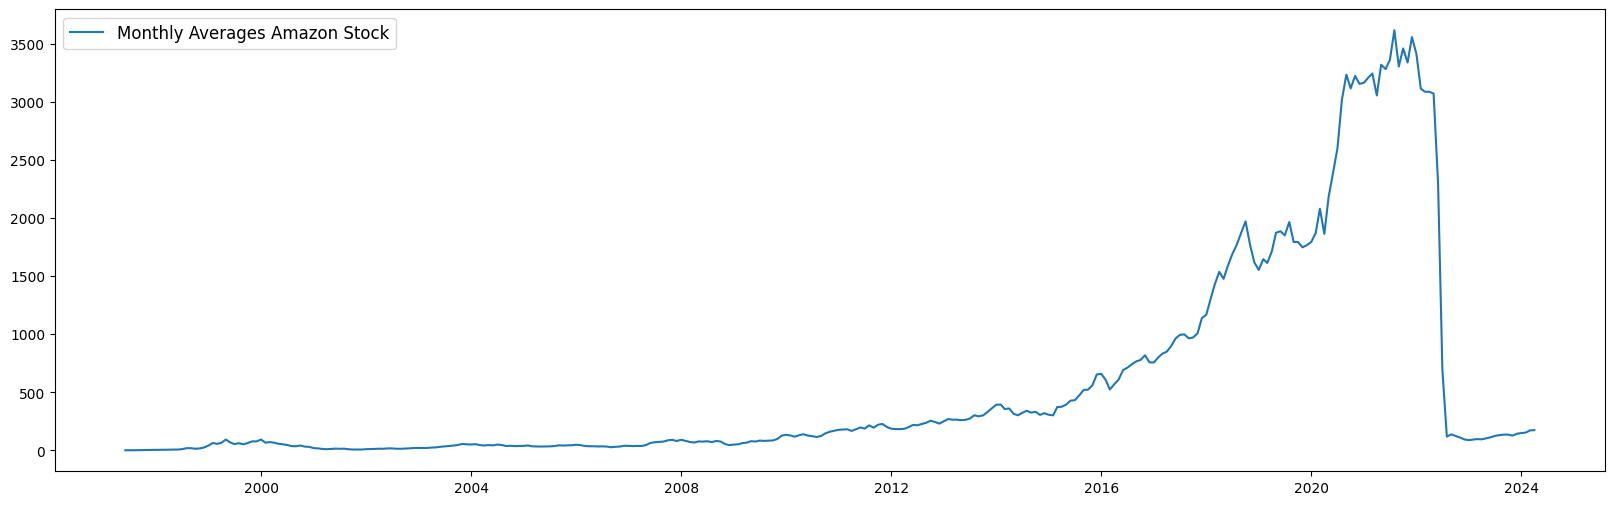

In [ ]:
amazon['Date'] = pd.to_datetime(amazon.Date)
newamazon = amazon.set_index('Date')
# Resample the data to the monthly level
monthly_data = newamazon[['Close', 'Open', 'High', 'Low', 'Volume']].resample('M').mean()
##Monthly Stock Price
fig = plt.figure(figsize=(20,6))
plt.plot(monthly_data['Close'],label='Monthly Averages Amazon Stock')
plt.legend(prop={'size': 12})
plt.show()

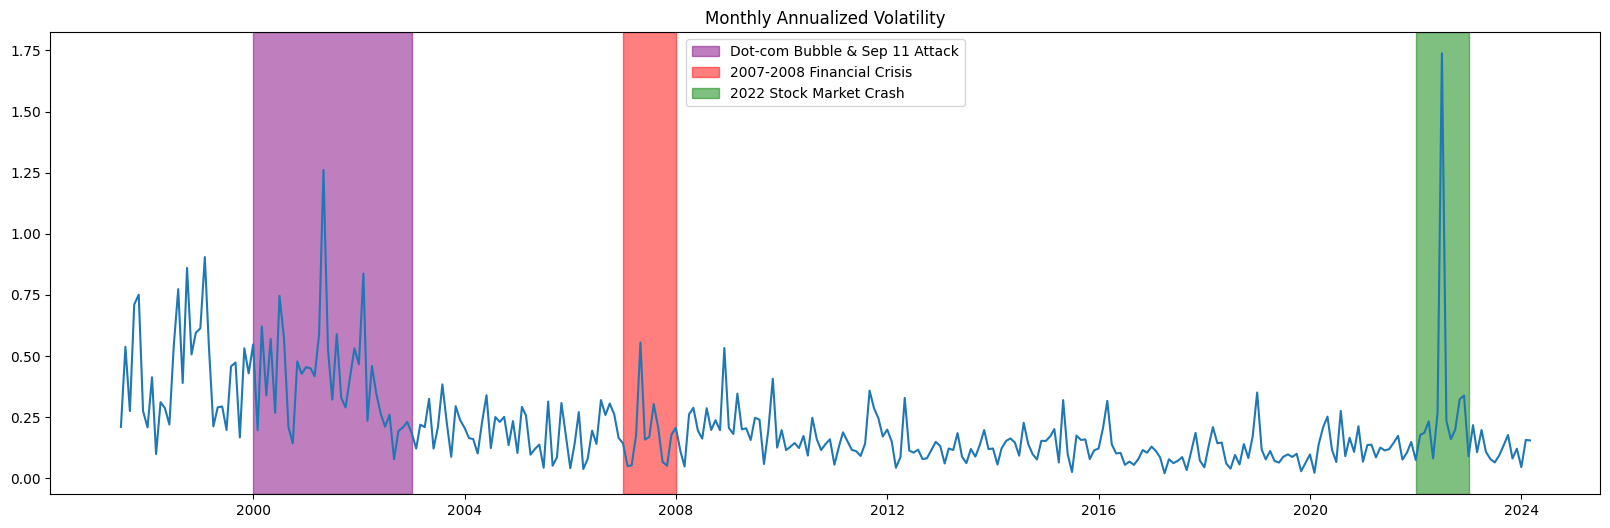

In [ ]:
# Calculate weekly returns using percentage change
weekly_returns = newamazon['Close'].pct_change()
weekly_returns.dropna(inplace=True)

# Resample to monthly data and calculate the standard deviation as a measure of volatility
# Then annualize the monthly volatility
monthly_volatility = weekly_returns.resample("M").std() * np.sqrt(12)

# Visualize major market events reflected in volatility
plt.figure(figsize=(20, 6))
plt.plot(monthly_volatility)
plt.axvspan('2000', '2003', color='purple', alpha=.5)
plt.axvspan('2007', '2008', color='red', alpha=.5)
plt.axvspan('2022', '2023', color='green', alpha=.5)
plt.title("Monthly Annualized Volatility")

# Add legend for major market events
l1 = mpatches.Patch(color='purple', alpha=.5, label="Dot-com Bubble & Sep 11 Attack")
l2 = mpatches.Patch(color='red', alpha=.5, label="2007-2008 Financial Crisis")
l3 = mpatches.Patch(color='green', alpha=.5, label="2022 Stock Market Crash")
plt.legend(handles=[l1, l2, l3])

plt.show()

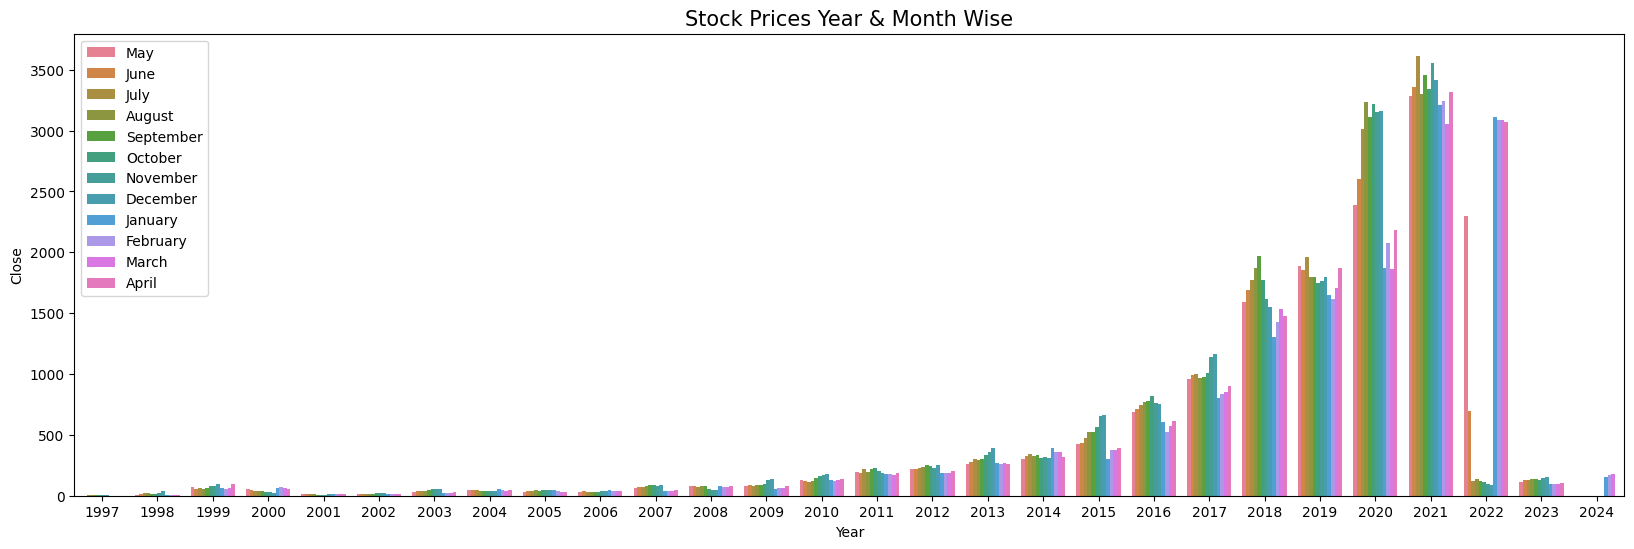

In [ ]:
monthly_data['Year'] = monthly_data.index.year
monthly_data['Month'] = monthly_data.index.strftime('%B')
monthly_data['Quarter'] = monthly_data.index.quarter
fig, ax = plt.subplots(figsize=(20,6))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="Year", y="Close",hue = 'Month',data=monthly_data)
a.set_title("Stock Prices Year & Month Wise",fontsize=15)
plt.legend(loc='upper left')
plt.show()

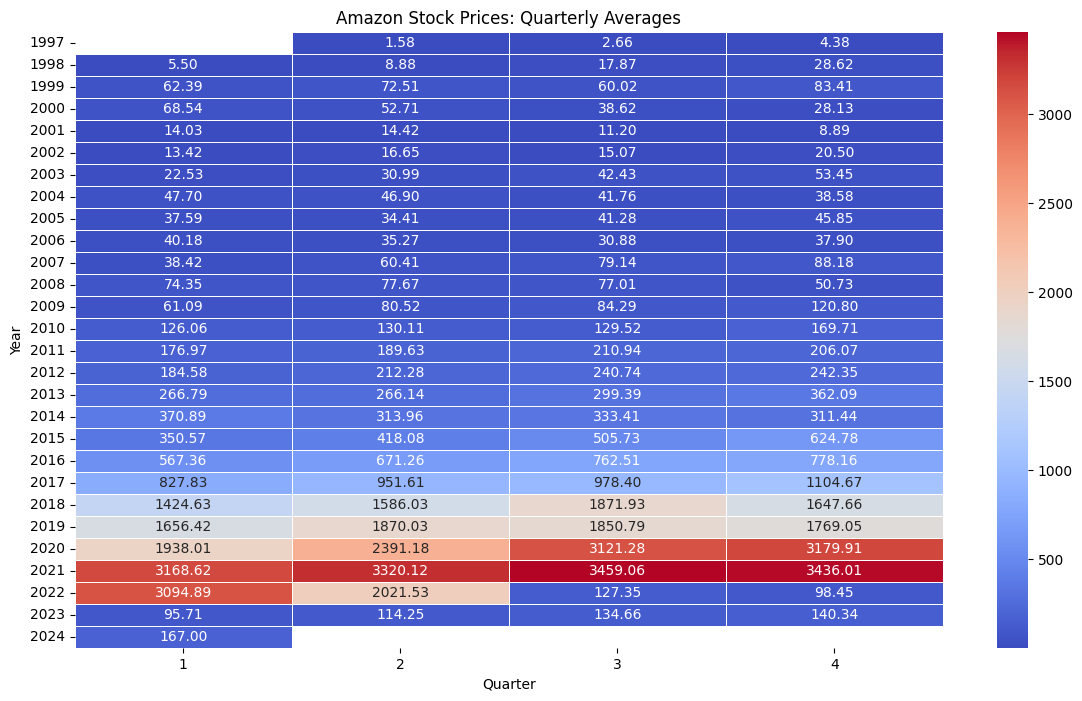

In [ ]:
quarter = monthly_data.groupby(["Year", "Quarter"])["Close"].mean().unstack()
plt.figure(figsize=(14, 8))
sns.heatmap(quarter, cmap="coolwarm", annot=True, fmt=".2f", linewidths=.5)
plt.title("Amazon Stock Prices: Quarterly Averages")
plt.show()

### Data Preparation

#### Target Construction

In [ ]:
# Create Log(Return)
# Calculate logarithmic returns
amazon['Log_Return'] = np.log(amazon['Close'] / amazon['Close'].shift(1))
amazon['Log_Return'].fillna(0, inplace=True)  # Handle NaN values resulting from the shift

#### Covariates construction

In [ ]:
# Calculate Simple Moving Average (SMA)
amazon['SMA_50'] = ta.sma(amazon['Close'], length=50)  # 50-period SMA
amazon['SMA_200'] = ta.sma(amazon['Close'], length=200)  # 200-period SMA

# Calculate Exponential Moving Average (EMA)
amazon['EMA_12'] = ta.ema(amazon['Close'], length=12)  # 12-period EMA
amazon['EMA_26'] = ta.ema(amazon['Close'], length=26)  # 26-period EMA

# Calculate the Stochastic Oscillator components
stoch = ta.stoch(amazon['High'], amazon['Low'], amazon['Close'])
amazon = amazon.join(stoch)

# Calculate Relative Strength Index (RSI)
amazon['RSI_14'] = ta.rsi(amazon['Close'], length=14)  # 14-period RSI

# Calculate Moving Average Convergence Divergence (MACD)
macd = ta.macd(amazon['Close'])
amazon = amazon.join(macd)

In [ ]:
amazon['Date'] = pd.to_datetime(amazon['Date'])
amazon.set_index('Date', inplace=True)

In [ ]:
# Handle NaN:
amazon.dropna(inplace=True)

In [ ]:
amazon.shape

(1200, 16)

In [ ]:
# Calculate split indices
split_idx_train = int(len(amazon) * 0.7)
split_idx_val = int(len(amazon) * 0.9)

# Drop the specified columns and define the features and labels
X_amazon = amazon.drop(['Log_Return'], axis=1)
y_amazon = amazon['Log_Return']  # Log_Return as the target variable

# Ensure that indices are reset before splitting to avoid potential issues
X_amazon.reset_index(drop=True, inplace=True)
y_amazon.reset_index(drop=True, inplace=True)

# Split into training, validation, and testing sets
X_amazon_train = X_amazon.iloc[:split_idx_train, :]
X_amazon_val = X_amazon.iloc[split_idx_train:split_idx_val, :]
X_amazon_test = X_amazon.iloc[split_idx_val:, :]

y_amazon_train = y_amazon.iloc[:split_idx_train]
y_amazon_val = y_amazon.iloc[split_idx_train:split_idx_val]
y_amazon_test = y_amazon.iloc[split_idx_val:]

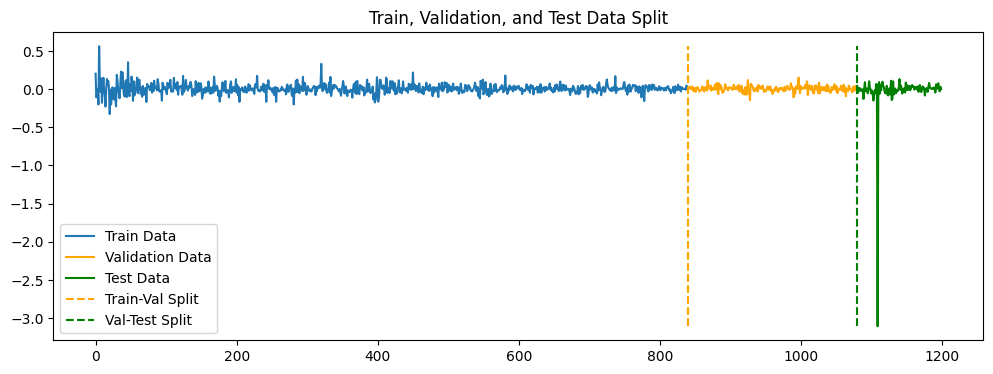

In [ ]:
# Indices for plotting
x_train = np.arange(len(y_amazon_train))
x_val = np.arange(len(y_amazon_train), len(y_amazon_train) + len(y_amazon_val))
x_test = np.arange(len(y_amazon_train) + len(y_amazon_val), len(y_amazon))

# Plotting
plt.figure(figsize=(12, 4))
plt.plot(x_train, y_amazon_train, label="Train Data")
plt.plot(x_val, y_amazon_val, color='orange', label="Validation Data")
plt.plot(x_test, y_amazon_test, color='green', label="Test Data")
plt.vlines(len(y_amazon_train), ymin=min(y_amazon.min(), y_amazon.min(), y_amazon.min()), ymax=max(y_amazon.max(), y_amazon.max(), y_amazon.max()), label='Train-Val Split', linestyles='dashed', colors='orange')
plt.vlines(len(y_amazon_train) + len(y_amazon_val), ymin=min(y_amazon.min(), y_amazon.min(), y_amazon.min()), ymax=max(y_amazon.max(), y_amazon.max(), y_amazon.max()), label='Val-Test Split', linestyles='dashed', colors='green')
plt.legend()
plt.title("Train, Validation, and Test Data Split")
plt.show()

### Data Preprocessing

In [ ]:
from sklearn.preprocessing import power_transform

# Fit the transformer on the training data and transform it
X_amazon_train_transformed = power_transform(X_amazon_train.to_numpy(), method='yeo-johnson')

# Transform the validation data using the same transformer
X_amazon_val_transformed = power_transform(X_amazon_val.to_numpy(), method='yeo-johnson')

# Transform the test data using the same transformer
X_amazon_test_transformed = power_transform(X_amazon_test.to_numpy(), method='yeo-johnson')

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_amazon_train_scaled = scaler.fit_transform(X_amazon_train_transformed)

# Transform the val data using the same scaler
X_amazon_val_scaled = scaler.transform(X_amazon_val_transformed)

# Transform the test data using the same scaler
X_amazon_test_scaled = scaler.transform(X_amazon_test_transformed)

In [ ]:
print(X_amazon_train_scaled.shape)
print(X_amazon_val_scaled.shape)
print(X_amazon_test_scaled.shape)

(840, 15)
(240, 15)
(120, 15)


### Models

#### Loss function: RMSE

##### RNNs

In [ ]:
!ls "/content/drive/My Drive/Colab Notebooks/Trading"

01_Strategy_Optimization.ipynb	anns.py     Data			__pycache__
anns.ipynb			arma.ipynb  IBM_price_prediction.ipynb


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Trading')
from anns import rnns, create_sequences_rnns, SimpleRNN, RMSELoss

In [ ]:
# Ensure y_amazon_train and y_test are numpy arrays
y_amazon_train = y_amazon_train.to_numpy() if isinstance(y_amazon_train, pd.Series) else y_amazon_train
y_amazon_val = y_amazon_val.to_numpy() if isinstance(y_amazon_val, pd.Series) else y_amazon_val
y_amazon_test = y_amazon_test.to_numpy() if isinstance(y_amazon_test, pd.Series) else y_amazon_test

# Create sequences
time_steps = 10
X_amazon_train_seq, y_amazon_train_seq = create_sequences_rnns(X_amazon_train_scaled, y_amazon_train, time_steps)
X_amazon_val_seq, y_amazon_val_seq = create_sequences_rnns(X_amazon_val_scaled, y_amazon_val, time_steps)
X_amazon_test_seq, y_amazon_test_seq = create_sequences_rnns(X_amazon_test_scaled, y_amazon_test, time_steps)

X_amazon_train_tensor = torch.tensor(X_amazon_train_seq, dtype=torch.float32)
y_amazon_train_tensor = torch.tensor(y_amazon_train_seq, dtype=torch.float32)
X_amazon_val_tensor = torch.tensor(X_amazon_val_seq, dtype=torch.float32)
y_amazon_val_tensor = torch.tensor(y_amazon_val_seq, dtype=torch.float32)
X_amazon_test_tensor = torch.tensor(X_amazon_test_seq, dtype=torch.float32)
y_amazon_test_tensor = torch.tensor(y_amazon_test_seq, dtype=torch.float32)

# Prepare data loaders
amazon_train_dataset = TensorDataset(X_amazon_train_tensor, y_amazon_train_tensor)
amazon_train_loader = DataLoader(dataset=amazon_train_dataset, batch_size=32, shuffle=True)
amazon_val_dataset = TensorDataset(X_amazon_val_tensor, y_amazon_val_tensor)
amazon_val_loader = DataLoader(dataset=amazon_val_dataset, batch_size=32, shuffle=False)

# Prepare data for prediction
amazon_predict_dataset = TensorDataset(X_amazon_test_tensor, y_amazon_test_tensor)
amazon_predict_loader = DataLoader(amazon_predict_dataset, batch_size=32, shuffle=False)

In [ ]:
X_amazon_train_tensor.shape

torch.Size([830, 10, 15])

###### Normal RNNs

In [ ]:
# Initialize the RNN model
amazon_rnns_rmse = SimpleRNN(input_size=15, hidden_size=20, num_layers=1, output_size=1)
optimizer = optim.Adam(amazon_rnns_rmse.parameters(), lr=0.001)
loss_function = RMSELoss()
epochs = 100

best_model_state, best_val_loss = rnns(amazon_rnns_rmse, amazon_train_loader, amazon_val_loader, epochs, optimizer, loss_function)

Epoch 1, Train Loss: 0.10027988255023956, Val Loss: 0.06622109562158585
Epoch 11, Train Loss: 0.0769374743103981, Val Loss: 0.049128659069538116
Epoch 21, Train Loss: 0.058446742594242096, Val Loss: 0.04110787436366081
Epoch 31, Train Loss: 0.04568004608154297, Val Loss: 0.04162067174911499
Epoch 41, Train Loss: 0.060517795383930206, Val Loss: 0.04222354665398598
Epoch 51, Train Loss: 0.0523991696536541, Val Loss: 0.0390777550637722
Epoch 61, Train Loss: 0.07165952026844025, Val Loss: 0.04393572360277176
Epoch 71, Train Loss: 0.047891341149806976, Val Loss: 0.04019252583384514
Epoch 81, Train Loss: 0.07390160113573074, Val Loss: 0.03914788365364075
Epoch 91, Train Loss: 0.05766863375902176, Val Loss: 0.040829699486494064


In [ ]:
amazon_rnns_rmse.load_state_dict(best_model_state)
amazon_rnns_rmse.eval()  # Set the model to evaluation mode

SimpleRNN(
  (rnn): RNN(15, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

In [ ]:
amazon_predictions = []
amazon_actuals = []

with torch.no_grad():
    for inputs, labels in amazon_predict_loader:
        outputs = amazon_rnns_rmse(inputs)
        if outputs.dim() > 1 and outputs.shape[1] == 1:
            outputs = outputs.squeeze(1)  # Make sure the output is [batch] if it's [batch, 1]

        # Store predictions and actual values
        amazon_predictions.extend(outputs.cpu().numpy())  # Convert tensor to numpy array if necessary
        amazon_actuals.extend(labels.cpu().numpy())

In [ ]:
amazon_rnns_rmse_predictions = np.array(amazon_predictions)
amazon_rnns_rmse_actuals = np.array(amazon_actuals)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming amazon_rnns_rmse_predictions and amazon_rnns_rmse_actuals are numpy arrays of predictions and actual values
# Convert predictions and actuals to binary classification problem (1 if positive or 0, 0 if negative)
amazon_rnns_rmse_predicted_labels = (amazon_rnns_rmse_predictions >= 0).astype(int)
amazon_rnns_rmse_actual_labels = (amazon_rnns_rmse_actuals >= 0).astype(int)

# Calculate classifier metrics
amazon_rnns_rmse_accuracy = accuracy_score(amazon_rnns_rmse_actual_labels, amazon_rnns_rmse_predicted_labels)
amazon_rnns_rmse_precision = precision_score(amazon_rnns_rmse_actual_labels, amazon_rnns_rmse_predicted_labels)
amazon_rnns_rmse_recall = recall_score(amazon_rnns_rmse_actual_labels, amazon_rnns_rmse_predicted_labels)
amazon_rnns_rmse_f1 = f1_score(amazon_rnns_rmse_actual_labels, amazon_rnns_rmse_predicted_labels)

# Print the classification metrics
print("Accuracy:", amazon_rnns_rmse_accuracy)
print("Precision:", amazon_rnns_rmse_precision)
print("Recall:", amazon_rnns_rmse_recall)
print("F1 Score:", amazon_rnns_rmse_f1)

Accuracy: 0.4636363636363636
Precision: 0.5
Recall: 0.4576271186440678
F1 Score: 0.4778761061946903


###### GA optimiser

In [ ]:
from anns import GAoptimizer_rnns_RMSE
if __name__ == "__main__":
    optimizer = GAoptimizer_rnns_RMSE(
        input_size=15,
        output_size=1,
        train_loader=amazon_train_loader,
        val_loader=amazon_val_loader,
        population_size=20,
        max_generations=50,
        epochs=100
    )
    optimizer.evolve()

    # Load the best model for prediction
    amazon_rnns_rmse_best_model = SimpleRNN(optimizer.input_size, optimizer.best_model_state['hidden_size'], optimizer.best_model_state['num_layers'], optimizer.output_size)
    amazon_rnns_rmse_best_model.load_state_dict(optimizer.best_model_state)
    amazon_rnns_rmse_best_model.eval()

    # Prediction
    predictions = []
    with torch.no_grad():
        for inputs in amazon_predict_loader:
            outputs = amazon_rnns_rmse_best_model(inputs)
            predictions.append(outputs.numpy())  # Collect the predictions

Generation: 1
Epoch 1, Train Loss: 0.09541992098093033, Val Loss: 0.05246614292263985
Epoch 11, Train Loss: 0.05564214289188385, Val Loss: 0.03691916540265083
Epoch 21, Train Loss: 0.04659445956349373, Val Loss: 0.03812139481306076
Epoch 31, Train Loss: 0.04592294245958328, Val Loss: 0.03704962879419327
Epoch 41, Train Loss: 0.05690427124500275, Val Loss: 0.0369122251868248
Epoch 51, Train Loss: 0.05049889162182808, Val Loss: 0.03834066912531853
Epoch 61, Train Loss: 0.05893148481845856, Val Loss: 0.03795343264937401
Epoch 71, Train Loss: 0.06714008003473282, Val Loss: 0.039355117827653885
Epoch 81, Train Loss: 0.07323131710290909, Val Loss: 0.03755057230591774
Epoch 91, Train Loss: 0.07385113090276718, Val Loss: 0.03779062256217003
Individual fitness: 0.03558361902832985
Epoch 1, Train Loss: 0.06786614656448364, Val Loss: 0.04066082835197449
Epoch 11, Train Loss: 0.05353986844420433, Val Loss: 0.03672831878066063
Epoch 21, Train Loss: 0.05977810174226761, Val Loss: 0.03620718792080879

KeyboardInterrupt: 

##### ANFIS

In [ ]:
X_amazon_train_anfis = torch.tensor(X_amazon_train_scaled, dtype=torch.float32)
y_amazon_train_anfis = torch.tensor(y_amazon_train, dtype=torch.float32)
X_amazon_val_anfis = torch.tensor(X_amazon_val_scaled, dtype=torch.float32)
y_amazon_val_anfis = torch.tensor(y_amazon_val, dtype=torch.float32)
X_amazon_test_anfis = torch.tensor(X_amazon_test_scaled, dtype=torch.float32)
y_amazon_test_anfis = torch.tensor(y_amazon_test, dtype=torch.float32)

In [ ]:
X_amazon_train_anfis.shape

torch.Size([840, 15])

###### Normal ANFIS

In [ ]:
from anns import ANFIS_RMSE
input_dim = X_amazon_train_anfis.shape[1]  # Number of features
functions = 10  # Number of Gaussian functions in the model
epochs = 100
learning_rate = 0.001

# Initialize the ANFIS model
amazon_anfis_rmse = ANFIS_RMSE(functions=functions, input_dim=input_dim)

# Train the model
amazon_anfis_rmse.fit(X_amazon_train_anfis, y_amazon_train_anfis
                      , X_amazon_val_anfis, y_amazon_val_anfis
                      , epochs, learning_rate)

# Predict on the test set
amazon_anfis_rmse_predictions = amazon_anfis_rmse.predict(X_amazon_test_anfis)

Epoch 1/100, Train Loss: 0.0326, Validation Loss: 0.0250
Epoch 11/100, Train Loss: 0.0045, Validation Loss: 0.0016
Epoch 21/100, Train Loss: 0.0042, Validation Loss: 0.0014
Epoch 31/100, Train Loss: 0.0041, Validation Loss: 0.0014
Epoch 41/100, Train Loss: 0.0040, Validation Loss: 0.0014
Epoch 51/100, Train Loss: 0.0039, Validation Loss: 0.0014
Epoch 61/100, Train Loss: 0.0039, Validation Loss: 0.0013
Epoch 71/100, Train Loss: 0.0038, Validation Loss: 0.0013
Epoch 81/100, Train Loss: 0.0038, Validation Loss: 0.0013
Epoch 91/100, Train Loss: 0.0037, Validation Loss: 0.0013
Best Validation Loss: 0.0013


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert to numpy arrays if not already
amazon_anfis_rmse_predictions = amazon_anfis_rmse_predictions.detach().cpu().numpy()
amazon_anfis_rmse_actuals = y_amazon_test_anfis.detach().cpu().numpy()

# Function to convert values to -1, 0, 1 based on sign
def sign_classify(values):
    return np.sign(values)

# Classify both predictions and actuals
predicted_signs = sign_classify(amazon_anfis_rmse_predictions)
actual_signs = sign_classify(amazon_anfis_rmse_actuals)

# Boolean array where predictions match actuals
matches = (predicted_signs == actual_signs).astype(int)

# Calculate metrics
amazon_anfis_rmse_accuracy = accuracy_score(matches, np.ones_like(matches))  # Since matches are 1 where signs agree
amazon_anfis_rmse_precision = precision_score(matches, np.ones_like(matches), average='binary')
amazon_anfis_rmse_recall = recall_score(matches, np.ones_like(matches), average='binary')
amazon_anfis_rmse_f1 = f1_score(matches, np.ones_like(matches), average='binary')

# Print the classification metrics
print("Accuracy:", amazon_anfis_rmse_accuracy)
print("Precision:", amazon_anfis_rmse_precision)
print("Recall:", amazon_anfis_rmse_recall)
print("F1 Score:", amazon_anfis_rmse_f1)

Accuracy: 0.5333333333333333
Precision: 0.5333333333333333
Recall: 1.0
F1 Score: 0.6956521739130436


###### GA Optimiser

In [ ]:
from anns import GAoptimizer_ANFIS_RMSE
# Define the number of input dimensions (features)
input_dim = 15

# Instantiate the GA optimizer
ga_optimizer = GAoptimizer_ANFIS_RMSE(
    model_class=ANFIS_RMSE,
    input_dim=input_dim,
    X_train=X_amazon_train_anfis,
    y_train=y_amazon_train_anfis,
    X_val=X_amazon_val_anfis,
    y_val=y_amazon_val_anfis,
    epochs=100,
    population_size=10,
    max_generations=50
)

# Run the genetic algorithm optimization
amazon_anfis_rmse_best_parameters = ga_optimizer.evolve()

# best_parameters now contains the best set of hyperparameters found by the GA
print("Optimized Parameters:", amazon_anfis_rmse_best_parameters)

Generation 1
Best Validation Loss this Generation: 0.0010870515834540129
Generation 2
Best Validation Loss this Generation: 0.0012856335379183292
Generation 3
Best Validation Loss this Generation: 0.0013048377586528659
Generation 4
Best Validation Loss this Generation: 0.0013963015517219901
Generation 5
Best Validation Loss this Generation: 0.0013460592599585652
Generation 6
Best Validation Loss this Generation: 0.001224331557750702
Generation 7
Best Validation Loss this Generation: 0.001308721723034978
Generation 8
Best Validation Loss this Generation: 0.0013052388094365597
Generation 9
Best Validation Loss this Generation: 0.0012621406931430101
Generation 10
Best Validation Loss this Generation: 0.001178518170490861
Generation 11
Best Validation Loss this Generation: 0.0013125158147886395
Generation 12
Best Validation Loss this Generation: 0.0012813899666070938
Generation 13
Best Validation Loss this Generation: 0.0012171409325674176
Generation 14
Best Validation Loss this Generation

TypeError: ANFIS_RMSE.__init__() missing 2 required positional arguments: 'functions' and 'input_dim'

#### Custom loss function

##### RNNs

###### Normal RNNs

In [ ]:
from anns import EnhancedSignAgreementLoss
# Initialize the RNN model
amazon_rnns_custom = SimpleRNN(input_size=15, hidden_size=20, num_layers=1, output_size=1)
optimizer = optim.Adam(amazon_rnns_custom.parameters(), lr=0.001)
loss_function = EnhancedSignAgreementLoss(loss_penalty=1000)
epochs = 100

best_model_state, best_val_loss = rnns(amazon_rnns_custom, amazon_train_loader, amazon_val_loader, epochs, optimizer, loss_function)

Epoch 1, Train Loss: 266.6753234863281, Val Loss: 223.96690368652344
Epoch 11, Train Loss: 166.6702423095703, Val Loss: 235.0277557373047
Epoch 21, Train Loss: 283.3357238769531, Val Loss: 233.72557067871094
Epoch 31, Train Loss: 266.66839599609375, Val Loss: 217.4495391845703
Epoch 41, Train Loss: 233.3377227783203, Val Loss: 222.6578369140625
Epoch 51, Train Loss: 250.00619506835938, Val Loss: 218.10060119628906
Epoch 61, Train Loss: 233.33761596679688, Val Loss: 235.0277099609375
Epoch 71, Train Loss: 233.33885192871094, Val Loss: 252.60626220703125
Epoch 81, Train Loss: 266.6684875488281, Val Loss: 235.6788330078125
Epoch 91, Train Loss: 250.00729370117188, Val Loss: 227.86636352539062


In [ ]:
amazon_rnns_custom.load_state_dict(best_model_state)
amazon_rnns_custom.eval()  # Set the model to evaluation mode

SimpleRNN(
  (rnn): RNN(15, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

In [ ]:
amazon_predictions = []
amazon_actuals = []

with torch.no_grad():
    for inputs, labels in amazon_predict_loader:
        outputs = amazon_rnns_custom(inputs)
        if outputs.dim() > 1 and outputs.shape[1] == 1:
            outputs = outputs.squeeze(1)  # Make sure the output is [batch] if it's [batch, 1]

        # Store predictions and actual values
        amazon_predictions.extend(outputs.cpu().numpy())  # Convert tensor to numpy array if necessary
        amazon_actuals.extend(labels.cpu().numpy())

In [ ]:
amazon_rnns_custom_predictions = np.array(amazon_predictions)
amazon_rnns_custom_actuals = np.array(amazon_actuals)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming amazon_rnns_rmse_predictions and amazon_rnns_rmse_actuals are numpy arrays of predictions and actual values
# Convert predictions and actuals to binary classification problem (1 if positive or 0, 0 if negative)
amazon_rnns_custom_predicted_labels = (amazon_rnns_custom_predictions >= 0).astype(int)
amazon_rnns_custom_actual_labels = (amazon_rnns_custom_actuals >= 0).astype(int)

# Calculate classifier metrics
amazon_rnns_custom_accuracy = accuracy_score(amazon_rnns_custom_actual_labels, amazon_rnns_custom_predicted_labels)
amazon_rnns_custom_precision = precision_score(amazon_rnns_custom_actual_labels, amazon_rnns_custom_predicted_labels)
amazon_rnns_custom_recall = recall_score(amazon_rnns_custom_actual_labels, amazon_rnns_custom_predicted_labels)
amazon_rnns_custom_f1 = f1_score(amazon_rnns_custom_actual_labels, amazon_rnns_custom_predicted_labels)

# Print the classification metrics
print("Accuracy:", amazon_rnns_custom_accuracy)
print("Precision:", amazon_rnns_custom_precision)
print("Recall:", amazon_rnns_custom_recall)
print("F1 Score:", amazon_rnns_custom_f1)

Accuracy: 0.4909090909090909
Precision: 0.5272727272727272
Recall: 0.4915254237288136
F1 Score: 0.5087719298245613


###### GA Optimizer

In [ ]:
from anns import GAoptimizer_rnns_custom
if __name__ == "__main__":
    optimizer = GAoptimizer_rnns_custom(
        input_size=15,
        output_size=1,
        train_loader=amazon_train_loader,
        val_loader=amazon_val_loader,
        population_size=20,
        max_generations=50,
        loss_penalty=1000,
        epochs=100
    )
    optimizer.evolve()

    # Load the best model for prediction
    amazon_rnns_custom_best_model = SimpleRNN(optimizer.input_size, optimizer.best_model_state['hidden_size'], optimizer.best_model_state['num_layers'], optimizer.output_size)
    amazon_rnns_custom_best_model.load_state_dict(optimizer.best_model_state)
    amazon_rnns_custom_best_model.eval()

    # Prediction
    predictions = []
    with torch.no_grad():
        for inputs in amazon_predict_loader:
            outputs = amazon_rnns_custom_best_model(inputs)
            predictions.append(outputs.numpy())  # Collect the predictions

Generation: 1
Epoch 1, Train Loss: 0.8044054508209229, Val Loss: 0.8912084698677063
Epoch 11, Train Loss: 0.8715740442276001, Val Loss: 0.9024795889854431
Epoch 21, Train Loss: 0.6068840026855469, Val Loss: 0.8244456052780151
Epoch 31, Train Loss: 0.6716068983078003, Val Loss: 0.8636319041252136
Epoch 41, Train Loss: 0.669012188911438, Val Loss: 0.824613094329834
Epoch 51, Train Loss: 1.0705088376998901, Val Loss: 0.9114030599594116
Epoch 61, Train Loss: 0.6020001769065857, Val Loss: 0.8302304744720459
Epoch 71, Train Loss: 0.4014081358909607, Val Loss: 1.0183560848236084
Epoch 81, Train Loss: 0.4691289961338043, Val Loss: 0.9374202489852905
Epoch 91, Train Loss: 0.46878883242607117, Val Loss: 0.8527361750602722


TypeError: '<' not supported between instances of 'tuple' and 'float'

##### ANFIS

###### Normal ANFIS

In [ ]:
from anns import ANFIS_CustomLoss

input_dim = X_amazon_train_anfis.shape[1]  # Number of features
functions = 10  # Number of Gaussian functions in the model
epochs = 100
learning_rate = 0.001

# Initialize the ANFIS model
amazon_anfis_custom = ANFIS_CustomLoss(functions=functions, input_dim=input_dim, loss_penalty=500)

# Train the model
amazon_anfis_custom.fit(X_amazon_train_anfis, y_amazon_train_anfis
                      , X_amazon_val_anfis, y_amazon_val_anfis
                      , epochs, learning_rate)

# Predict on the test set
amazon_anfis_custom_predictions = amazon_anfis_custom.predict(X_amazon_test_anfis)

Epoch 1/100, Train Loss: 264.3251, Val Loss: 291.6980
Epoch 11/100, Train Loss: 260.7191, Val Loss: 270.8351
Epoch 21/100, Train Loss: 236.9090, Val Loss: 208.3348
Epoch 31/100, Train Loss: 236.9090, Val Loss: 208.3347
Epoch 41/100, Train Loss: 236.9090, Val Loss: 208.3347
Epoch 51/100, Train Loss: 236.9090, Val Loss: 208.3347
Epoch 61/100, Train Loss: 236.9089, Val Loss: 208.3347
Epoch 71/100, Train Loss: 230.9564, Val Loss: 202.0847
Epoch 81/100, Train Loss: 233.3373, Val Loss: 191.6680
Epoch 91/100, Train Loss: 232.7420, Val Loss: 187.5013
Best Validation Loss: 183.3347


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert to numpy arrays if not already
amazon_anfis_custom_predictions = amazon_anfis_custom_predictions.detach().cpu().numpy()
amazon_anfis_custom_actuals = y_amazon_test_anfis.detach().cpu().numpy()

# Function to convert values to -1, 0, 1 based on sign
def sign_classify(values):
    return np.sign(values)

# Classify both predictions and actuals
predicted_signs = sign_classify(amazon_anfis_custom_predictions)
actual_signs = sign_classify(amazon_anfis_custom_actuals)

# Boolean array where predictions match actuals
matches = (predicted_signs == actual_signs).astype(int)

# Calculate metrics
amazon_anfis_custom_accuracy = accuracy_score(matches, np.ones_like(matches))  # Since matches are 1 where signs agree
amazon_anfis_custom_precision = precision_score(matches, np.ones_like(matches), average='binary')
amazon_anfis_custom_recall = recall_score(matches, np.ones_like(matches), average='binary')
amazon_anfis_custom_f1 = f1_score(matches, np.ones_like(matches), average='binary')

# Print the classification metrics
print("Accuracy:", amazon_anfis_custom_accuracy)
print("Precision:", amazon_anfis_custom_precision)
print("Recall:", amazon_anfis_custom_recall)
print("F1 Score:", amazon_anfis_custom_f1)

Accuracy: 0.6
Precision: 0.6
Recall: 1.0
F1 Score: 0.7499999999999999


###### GA optimizer

In [ ]:
from anns import GAoptimizer_ANFIS_custom
# Define the number of input dimensions (features)
input_dim = 15

# Instantiate the GA optimizer
amazon_anfis_custom_ga_optimizer = GAoptimizer_ANFIS_custom(
    model_class=ANFIS_RMSE,
    input_dim=input_dim,
    X_train=X_amazon_train_anfis,
    y_train=y_amazon_train_anfis,
    X_val=X_amazon_val_anfis,
    y_val=y_amazon_val_anfis,
    epochs=100,
    loss_penalty=1000
    population_size=10,
    max_generations=50
)

# Run the genetic algorithm optimization
amazon_anfis_custom_best_parameters = amazon_anfis_custom_ga_optimizer.evolve()

# best_parameters now contains the best set of hyperparameters found by the GA
print("Optimized Parameters:", amazon_anfis_custom_best_parameters)

## Cac

## IBM

## Microsoft

## Nasdaq

## Sp500